# Exploratory data analysis and clustering 

## Pre-processing

* Handel null & duplicates
* Remove Extraneous Information (URL, joind date..) 


## Data quality 
* Length Distributions
* TTR

## data cleaning and tokenisation 
* Stop-word removal 
* Remove punctualtion 
* Remove URL, @%/... 
* Stemming 
* Lem
* Contractions


## Objectives 

• To exaine the language used by people with OCD. Compare words used to describe experinces on social network with the words used in the assessments tools for symptoms describtion.
* Appling unsupervised machine learning methods(clustering) 
• The reason of clusering is to investigate weather the observations of each cluster reflect any similarities or differences with the formal assessments tool of OCD. In other word, to look the words used in the assesment tool such as YALE-BROWN for OCD syptomes desccribtion and compare them with the words used by people with OCD using online plateform to discuess their symptomes and experinces.  

## Methods
# Words representatiion: 
• Tf-idf 
• bag-of-word(LDA)
• Word-embiding using (Glove) and (fasttext), embeddings_average.

• Key difference is Glove treats each word in corpus like an atomic entity and generates a vector for each word. In this sense Glove is very much like word2vec- both treat words as the smallest unit to train on.

Fasttext which is essentially an extension of word2vec model, treats each word as composed of character ngrams. So the vector for a word is made of the sum of this character n grams. This difference enables fasttext to generate better word embeddings for rare words ( even if words are rare their character n grams are still shared with other words - hence the embeddings can still be good)
Out of vocabulary words - they can construct the vector for a word from its character n grams even if word doesn't appear in training corpus. Both Glove and word2vec can't.
# For clustering 
• K-means
• DB
• LDA

## Import libraries 

In [ ]:
import pandas as pd
import copy 
import math

# visuaLisation 
import seaborn as sns
import matplotlib.pyplot as plt

#ML & NLP
import numpy as np

#from pycontractions import collections
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
stop_words = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer, PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

import spacy
from spacy import displacy 

#import contractions

import gensim
from gensim.utils import simple_preprocess

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import precision_recall_fscore_support,accuracy_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import MeanShift, estimate_bandwidth
import random 
import re
import string
import ast 

In [ ]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

## Data Wrangling
*Load and Data Quality Checks

**data (data from ocd forum)**
**data2 (data from raddit)**

In [ ]:
data = pd.read_csv('../EDA/OCD2_updated.csv', dtype=str)
data2 = pd.read_csv('../EDA/ocd_top_1000.csv', header=1, dtype=str)

In [ ]:
data.head()

In [ ]:
data2 = data2.drop(index=1)


In [ ]:
data2.head()

In [ ]:
nRow, nCol = data.shape
print(f'there are {nRow} rows and {nCol} columns in the Forum data')
nRow, nCol = data2.shape
print(f'there are {nRow} rows and {nCol} columns in the Reddit data')

## Null Analysis

In [ ]:
data.isnull().sum()

In [ ]:
data2.isnull().sum()

## Handle Null Descriptions

In [ ]:
# drop empty descriptions
data = data[data['Description'].notna()]

In [ ]:
# drop empty descriptions
data2 = data2[data2['post'].notna()]

## Handle Null Dates

In [ ]:
# drop empty dates
data = data[data['Date'].notna()]
data2 = data2[data2['date'].notna()]

In [ ]:
# remove this 'header' row
data.drop(axis=0, index=13043, inplace=True)

In [ ]:
data.isnull().sum()

In [ ]:
data2.isnull().sum()

## Duplicate Analysis

In [ ]:
duplicate = data['Description'].duplicated()
print(f'there are {sum(duplicate)} duplicates')

In [ ]:
# de-duplicate the dataset (for descriptions only)
data = data[data.duplicated(subset='Description')==False]
data.shape

In [ ]:
duplicate = data2['post'].duplicated()
print(f'there are {sum(duplicate)} duplicates')

In [ ]:
# de-duplicate the dataset (for descriptions only)
data2 = data2[data2.duplicated(subset='post')==False]
data2.shape

## Data Quality


### Remove Extraneous Information

In [ ]:
# items like URLs, ids, timeOfDay, JoinDate, etc unlikely to be relevant
data.drop(columns=['Time','Profile_name','Joined','Location','impairment ','Insight', 'obsession\Compulsive ','Profile_URL'], axis=1, inplace=True)
data2.drop(columns=['author', 'url'], axis=1, inplace=True)
        

### Make Type Rich

In [ ]:
# make Date's real datetimes
data['Date'] = pd.to_datetime(data['Date'])
data2['date']= pd.to_datetime(data2['date'],errors='coerce')

In [ ]:
# identify poorly formed dates
data2[data2['date'].isna()]

In [ ]:
# remove bad dates
data2 = data2[data2['date'].notna()]

In [ ]:
data.info()

In [ ]:
data2.info()

### Make Datasets More Homogeneous

In [ ]:
# homogenize columns
data2.rename(mapper={'post': 'Description'}, axis=1, inplace=True)
data2.rename(mapper={'date': 'Date'}, axis=1, inplace=True)
data2.rename(mapper={'title': 'Title'}, axis=1, inplace=True)
data.rename(mapper={'experience': 'Title'}, axis=1, inplace=True)

In [ ]:
#dictionary `contractions` to replace all the short text values with their corresponding the expanded values
#you can add more values as per your requirements.

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and "}

In [ ]:
from nltk.stem import WordNetLemmatizer

## Tokenisation 

In [ ]:
def tokenizeText(text, includeStopWords=False, includePunctuation=True, isLowerCase=True, separateDoc=False, includeStemmWords= True, includeLemWords=True,regex=True):
    '''
    Given text, return a list of tokens (words)
    
    Options:
        includePunctuation = True (default) if the bag of words include punctuation as token
                           = False if the bag of words exclude punctuation.
        includeStopWords = True if stop words are not cleaned from bag of words
                         = False (default) to return clean words without stop words.
        isLowerCase = True (default) if all words are transformed into lower case
                    = False if no transformation of case
        separateDoc = True (provide list of list of tokens one list per data item)
                    = False (provide flat list of tokens for entire data set)
       
    '''
    all_thought = [] # our corpus
    lines = text['Description'].values.tolist()
    for text in lines:
        if includePunctuation==True:
            # include punctuation as part of token or word
            tokens = [word for token in nltk.sent_tokenize(text) 
                      for word in nltk.word_tokenize(token)]
        else:
            # remove punctuation, words only
            tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
            tokens = [word for token in nltk.sent_tokenize(text) 
                      for word in tokenizer.tokenize(token)]
    
        if isLowerCase==True:
            tokens=[word.lower() for word in tokens]
            
       # if contWords == True:
           # tokens = [contractions.fix(word) for word in tokens]  #contraction
           # remove_digits = str.maketrans('', '', digits)
           # tokens = [w.translate(remove_digits) for w in tokens] 
           # tokens = [word for word in tokens if word]
            



        if includeStopWords==False:
            stopWords=set(nltk.corpus.stopwords.words('english'))  # load stop words
            tokens = [t for t in tokens if t not in stopWords]     # cleaning word from stop words 

        if includeStemmWords== True:
            porter = PorterStemmer()
            #tokens = [t for t in tokens 
                        #for t in porter.stem(t)]
            tokens = [porter.stem(word) for word in tokens]

        if includeLemWords == True:
            stemmer = WordNetLemmatizer()
            #tokens = [t for t in tokens 
                        #for t in lemmatizer.lemmatize(t)]
            tokens = [stemmer.lemmatize(word) for word in tokens]
            
        
        if regex == True: 
            """Remove URLs from a text string"""
            #tokens = re.sub('[0-9]+', '', str(tokens))
            #tokens =re.sub(r'http\S+', '', str(tokens))
            #tokens =re.sub(r'[!@#$^&%*()+=-[]\/{}|:<>?,.]', '', str(tokens), flags=re.I)
            
            
            #ree = ["http\S+","0-9","!@#$^&%*()+=-[]\/{}|:<>?,.","6a564be8077bb7751060e1012b88acc68a2a476b", "e8qpg3i3k6m61"]
            #tokens = [t for t in tokens if t not in ree]
            #tokens =re.sub(r"http\S+", "", tokens)
            #tokens =re.sub(r"[!@#$^&%*()+=-[]\/{}|:<>?,.]", "", text, flags=re.I)
        #if contraction == True:
             #for key in contractions:
                    #x = contractions[key]
                    #tokens = x.replace(key, x)
                    
            # Remove all the special characters
            #tokens = re.sub(r'\W', ' ', str(tokens))
            # remove all single characters
            #tokens = re.sub(r'\s+[a-zA-Z]\s+', ' ', tokens)
            # Remove single characters from the start
            #tokens = re.sub(r'\^[a-zA-Z]\s+', ' ', tokens)
            # Substituting multiple spaces with single space
            #tokens = re.sub(r'\s+', ' ', tokens, flags=re.I)
            #ree = ['http\S+","0-9","!@#$^&%*()+=-[]\/{}|:<>?,.', '\W', '\s+[a-zA-Z]\s+', '\^[a-zA-Z]\s+']
            ree = ['[^a-zA-Z ]/g']
            tokens = [t for t in tokens if t not in ree]
            
            
            




  
    

        if (separateDoc):
            all_thought.append(tokens)
        else:
            all_thought+=tokens
    return all_thought






In [ ]:
# remove this on super-computer
#data = data.sample(frac=0.1)

In [ ]:
#: no need to caLculate this for every n-gram; punctuation should be removed for n-grams
words_doc = tokenizeText(data, includeStopWords=False, isLowerCase=True, includePunctuation=False, separateDoc=True, includeStemmWords= False, includeLemWords=True,regex=True)
words_flat = tokenizeText(data, includeStopWords=True, isLowerCase=True, includePunctuation=False, separateDoc=False, includeStemmWords= False, includeLemWords=True,regex=True)

In [ ]:
#: no need to caLculate this for every n-gram; punctuation should be removed for n-grams
words_doc2 = tokenizeText(data2, includeStopWords=False, isLowerCase=True, includePunctuation=False, separateDoc=True, includeStemmWords= False, includeLemWords=True,regex=True)
words_flat2 = tokenizeText(data2, includeStopWords=True, isLowerCase=True, includePunctuation=False, separateDoc=False, includeStemmWords= False, includeLemWords=True,regex=True)

In [ ]:
words_flat[1:3]

In [ ]:
words_doc[1]

In [ ]:
words_doc2[100]

In [38]:
words_doc[20]

['hello',
 'gang',
 'asked',
 'earlier',
 'friend',
 'would',
 'lend',
 'laptop',
 'albeit',
 'reluctantly',
 'dig',
 'others',
 'touching',
 'belonging',
 'agreed',
 'proviso',
 'friend',
 'kept',
 'environment',
 'used',
 'clean',
 'would',
 'wash',
 'hand',
 'handling',
 'food',
 'touching',
 'keyboard',
 'request',
 'created',
 'something',
 'atmosphere',
 'appreciate',
 'need',
 'cleaniliness',
 'driven',
 'ocd',
 'surely',
 'case',
 'ensuring',
 'stuff',
 'remains',
 'tiptop',
 'condition',
 'possible',
 'really',
 'take',
 'care',
 'belonging',
 'would',
 'horrified',
 'returned',
 'le',
 'pristine',
 'condition',
 'order']

In [39]:
words_doc2[0]

['wanted',
 'pray',
 'god',
 'something',
 'using',
 'thought',
 'praying',
 'thought',
 'conversation',
 'brother',
 'father',
 'drew',
 'attention',
 'praying',
 'thought',
 'continued',
 'without',
 'paying',
 'attention',
 'cause',
 'focused',
 'conversation',
 '30',
 '60',
 'second',
 'started',
 'worrying',
 'without',
 'knowing',
 'exactly',
 'randomly',
 'started',
 'worrying',
 'may',
 'messed',
 'word',
 'kept',
 'repeating',
 'mistaken',
 'word',
 'without',
 'realising',
 'mistake',
 'maybe',
 'made',
 'look',
 'like',
 'asking',
 'something',
 'bad',
 'cant',
 'remember',
 'making',
 'mistake',
 'maybe',
 'hypothesis',
 'paying',
 'attention',
 'thought',
 'made',
 'mistake',
 'forgot',
 'subconscious',
 'remembers',
 'god',
 'thought',
 'accidental',
 'prayer',
 'real',
 'prayer',
 'kept',
 'repeating',
 'head',
 'god',
 'thought',
 'wanted',
 'past',
 'said',
 'god',
 'mistake',
 'may',
 'happen',
 'prayer',
 'matter',
 'say',
 'think',
 'without',
 'never',
 'accept',
 

## 1-gram and n-gram Analysis

In [40]:
' '.join(words_doc2[0])

'wanted pray god something using thought praying thought conversation brother father drew attention praying thought continued without paying attention cause focused conversation 30 60 second started worrying without knowing exactly randomly started worrying may messed word kept repeating mistaken word without realising mistake maybe made look like asking something bad cant remember making mistake maybe hypothesis paying attention thought made mistake forgot subconscious remembers god thought accidental prayer real prayer kept repeating head god thought wanted past said god mistake may happen prayer matter say think without never accept thought prayer protecet wanted safe rope would worry similar case like god thought changed opinion bad something wanted could focus prayer remember feeling little anxious cant remember making mistake sure hypothesis really made mistake want thing explained god many time make mistake thought prayer etc never accept matter say worry worry tired ocd'

In [41]:
four_grams = list(ngrams(words_flat,4))
fdist = nltk.FreqDist(four_grams)
fdist.most_common(50)

[(('i', 'don', 't', 'know'), 7540),
 (('i', 'don', 't', 'want'), 4583),
 (('don', 't', 'want', 'to'), 4559),
 (('i', 'feel', 'like', 'i'), 4060),
 (('don', 't', 'know', 'what'), 3256),
 (('know', 'what', 'to', 'do'), 2970),
 (('and', 'i', 'don', 't'), 2618),
 (('t', 'know', 'what', 'to'), 2300),
 (('i', 'just', 'want', 'to'), 2055),
 (('but', 'i', 'don', 't'), 1965),
 (('don', 't', 'know', 'if'), 1926),
 (('i', 'm', 'going', 'to'), 1914),
 (('i', 'don', 't', 'think'), 1834),
 (('feel', 'like', 'i', 'm'), 1798),
 (('i', 'm', 'not', 'sure'), 1793),
 (('i', 'just', 'don', 't'), 1730),
 (('but', 'i', 'can', 't'), 1678),
 (('don', 't', 'know', 'how'), 1658),
 (('at', 'the', 'moment', 'i'), 1651),
 (('i', 'don', 't', 'have'), 1604),
 (('and', 'i', 'can', 't'), 1502),
 (('i', 'just', 'can', 't'), 1472),
 (('if', 'i', 'don', 't'), 1377),
 (('that', 'i', 'don', 't'), 1361),
 (('i', 'am', 'going', 'to'), 1338),
 (('i', 'm', 'trying', 'to'), 1097),
 (('i', 'don', 't', 'feel'), 1086),
 (('at', 'th

In [42]:
five_grams = list(ngrams(words_flat,5))
fdist = nltk.FreqDist(five_grams)
fdist.most_common(50)

[(('i', 'don', 't', 'want', 'to'), 3486),
 (('don', 't', 'know', 'what', 'to'), 2205),
 (('i', 'don', 't', 'know', 'what'), 2202),
 (('t', 'know', 'what', 'to', 'do'), 2016),
 (('i', 'don', 't', 'know', 'if'), 1638),
 (('i', 'don', 't', 'know', 'how'), 1189),
 (('i', 'feel', 'like', 'i', 'm'), 1071),
 (('don', 't', 'know', 'how', 'to'), 978),
 (('and', 'i', 'don', 't', 'know'), 896),
 (('i', 'just', 'don', 't', 'know'), 850),
 (('know', 'what', 'to', 'do', 'i'), 828),
 (('don', 't', 'want', 'to', 'be'), 787),
 (('i', 'don', 't', 'think', 'i'), 775),
 (('to', 'the', 'point', 'where', 'i'), 702),
 (('don', 't', 'know', 'if', 'i'), 673),
 (('dont', 'know', 'what', 'to', 'do'), 670),
 (('i', 'didn', 't', 'want', 'to'), 627),
 (('i', 'don', 't', 'know', 'why'), 622),
 (('but', 'i', 'don', 't', 'know'), 577),
 (('i', 'm', 'not', 'sure', 'if'), 562),
 (('and', 'i', 'don', 't', 'want'), 553),
 (('i', 'feel', 'like', 'i', 'am'), 531),
 (('i', 'can', 't', 'seem', 'to'), 529),
 (('i', 'dont', 'kn

In [43]:
four_grams2 = list(ngrams(words_flat2,4))
fdist = nltk.FreqDist(four_grams2)
fdist.most_common(50)

[(('i', 'don', 't', 'know'), 175),
 (('i', 'feel', 'like', 'i'), 98),
 (('i', 'don', 't', 'want'), 93),
 (('don', 't', 'want', 'to'), 85),
 (('don', 't', 'know', 'what'), 71),
 (('know', 'what', 'to', 'do'), 58),
 (('t', 'know', 'what', 'to'), 53),
 (('and', 'i', 'don', 't'), 52),
 (('don', 't', 'know', 'how'), 45),
 (('i', 'don', 't', 'have'), 44),
 (('but', 'i', 'don', 't'), 43),
 (('feel', 'like', 'i', 'm'), 42),
 (('i', 'just', 'want', 'to'), 41),
 (('i', 'don', 't', 'think'), 39),
 (('but', 'i', 'can', 't'), 35),
 (('don', 't', 'know', 'if'), 33),
 (('if', 'i', 'don', 't'), 32),
 (('i', 'can', 't', 'stop'), 28),
 (('t', 'want', 'to', 'be'), 28),
 (('i', 'don', 't', 'really'), 28),
 (('t', 'know', 'how', 'to'), 27),
 (('i', 'm', 'going', 'to'), 27),
 (('to', 'the', 'point', 'where'), 27),
 (('i', 'm', 'not', 'sure'), 26),
 (('that', 'i', 'don', 't'), 25),
 (('i', 'm', 'trying', 'to'), 24),
 (('and', 'i', 'feel', 'like'), 24),
 (('the', 'point', 'where', 'i'), 23),
 (('and', 'i', 'c

In [44]:
five_grams2 = list(ngrams(words_flat2,5))
fdist = nltk.FreqDist(five_grams2)
fdist.most_common(50)

[(('i', 'don', 't', 'want', 'to'), 70),
 (('don', 't', 'know', 'what', 'to'), 52),
 (('t', 'know', 'what', 'to', 'do'), 49),
 (('i', 'don', 't', 'know', 'what'), 48),
 (('i', 'don', 't', 'know', 'how'), 36),
 (('i', 'don', 't', 'know', 'if'), 31),
 (('don', 't', 'want', 'to', 'be'), 26),
 (('don', 't', 'know', 'how', 'to'), 25),
 (('but', 'i', 'don', 't', 'know'), 23),
 (('i', 'feel', 'like', 'i', 'm'), 22),
 (('to', 'the', 'point', 'where', 'i'), 20),
 (('know', 'what', 'to', 'do', 'i'), 19),
 (('because', 'the', 'last', 'time', 'i'), 18),
 (('the', 'last', 'time', 'i', 'did'), 18),
 (('last', 'time', 'i', 'did', 'that'), 18),
 (('time', 'i', 'did', 'that', 'something'), 18),
 (('i', 'did', 'that', 'something', 'bad'), 18),
 (('did', 'that', 'something', 'bad', 'happened'), 18),
 (('that', 'something', 'bad', 'happened', 'the'), 18),
 (('something', 'bad', 'happened', 'the', 'next'), 18),
 (('bad', 'happened', 'the', 'next', 'day'), 18),
 (('i', 'feel', 'like', 'i', 'have'), 16),
 (('

## Analysis of Non-Stop Words

In [45]:
ns_words = tokenizeText(data, includeStopWords=False, isLowerCase=True, includePunctuation=False, separateDoc=False, includeStemmWords= False, includeLemWords=False,regex=True)
ns_words2 = tokenizeText(data2, includeStopWords=False, isLowerCase=True, includePunctuation=False, separateDoc=False, includeStemmWords= False, includeLemWords=False,regex=True)


In [46]:
p = Counter(" ".join(ns_words).split()).most_common(1000)
result = pd.DataFrame(p, columns=['Word', 'Frequency'])
result.head(100)

,Word,Frequency
0,ocd,93275
1,like,64312
2,feel,59296
3,know,52203
4,really,46394
...,...,...
95,intrusive,9304
96,worry,9292
97,may,9290
98,days,9170


In [47]:
p2 = Counter(" ".join(ns_words2).split()).most_common(1000)
result2 = pd.DataFrame(p2, columns=['Word', 'Frequency'])
result2.head(100)

,Word,Frequency
0,like,1299
1,ocd,1144
2,feel,787
3,know,729
4,thoughts,642
...,...,...
95,little,120
96,start,119
97,stuff,119
98,told,118


## Length Distributions

In [48]:
data['Desc-Char-Length'] = data['Description'].apply(len)
data['Desc-Word-Length'] = data['Description'].apply(lambda x: len(x.split()))
data.describe()

,Desc-Char-Length,Desc-Word-Length
count,56838.000000,56838.000000
mean,1119.453095,215.485327
std,1187.024929,224.866728
min,1.000000,0.000000
25%,436.000000,84.000000
50%,805.000000,156.000000
75%,1400.000000,271.000000
max,32759.000000,5733.000000


In [49]:
data2['Desc-Char-Length'] = data2['Description'].apply(len)
data2['Desc-Word-Length'] = data2['Description'].apply(lambda x: len(x.split()))
data2.describe()

,Desc-Char-Length,Desc-Word-Length
count,889.000000,889.000000
mean,993.750281,188.223847
std,1267.969695,237.496402
min,5.000000,1.000000
25%,345.000000,66.000000
50%,641.000000,122.000000
75%,1191.000000,226.000000
max,16753.000000,3066.000000


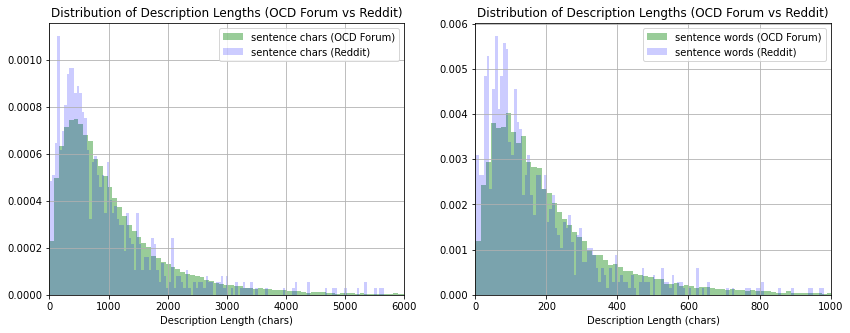

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
axes[0].hist(data['Desc-Char-Length'], bins=400, alpha=0.4, label='sentence chars (OCD Forum)', color='g', density=True)
axes[0].hist(data2['Desc-Char-Length'], bins=400, alpha=0.2, label='sentence chars (Reddit)', color='b', density=True)
axes[1].hist(data['Desc-Word-Length'], bins=400, alpha=0.4, label='sentence words (OCD Forum)', color='g', density=True) 
axes[1].hist(data2['Desc-Word-Length'], bins=400, alpha=0.2, label='sentence words (Reddit)', color='b', density=True) 
axes[0].set_xlim([0,6000])
axes[1].set_xlim([0,1000])
for ax in axes:
    ax.set_title('Distribution of Description Lengths (OCD Forum vs Reddit)')
    ax.set_xlabel('Description Length (chars)')
    ax.grid()
    ax.legend()

## Length Abnormalities

In [51]:
# how many descriptions are oddly short? Note sure how we can classify these
data[data['Desc-Word-Length']<20].shape

(1602, 6)

In [52]:
data[data['Desc-Word-Length']<20]['Description'].iloc[2:6]

60    Ok thanks alot.\nEdited August 7, 2007 by Guest
66         ......\nEdited July 13, 2018 by don't know
67          deleted\nEdited October 21, 2008 by Guest
68      ......\nEdited December 1, 2018 by don't know
Name: Description, dtype: object

In [53]:
# get names of indexes
index_names = data[data['Desc-Word-Length']<20].index 
# drop these row indexes 
# from dataFrame 
data.drop(index_names, inplace = True)

In [54]:
# how many descriptions are oddly short? Note sure how we can classify these
data2[data2['Desc-Word-Length']<20].shape

(49, 5)

In [55]:
data2[data2['Desc-Word-Length']<20]['Description'].iloc[2:6]

87                I feel so sick and disgusted with this
123    Reddit has become a big compulsion of mine. Si...
126    And yes this ocd is my fault. I made me distru...
146                                  Edit: girl in red**
Name: Description, dtype: object

In [56]:
# get names of indexes 
index_names = data2[data2['Desc-Word-Length']<20].index 
# drop these row indexes 
# from dataFrame 
data2.drop(index_names, inplace = True)

## TTR

In [57]:
#data['TTR'] = [len(set(words))/(1+len(words)) for words in words_doc]
#data2['TTR'] = [len(set(words))/(1+len(words)) for words in words_doc2]

In [58]:
#%matplotlib inline
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,5))
#ax.hist(data['TTR'], bins=140, alpha=0.4, label='TTR (OCD Forum)', color='g', density=True)
#ax.hist(data2['TTR'], bins=140, alpha=0.2, label='TTR (OCD Forum)', color='b', density=True)
#ax.set_title('Distribution of TTR')
#ax.set_xlabel('Type/Token Ratio')
#ax.grid()
#ax.legend();

## Clustering 

### Vectorization

* Adjust the max and min parameters

In [ ]:
def explore_df_range(dataset, maxdfr, mindfr):
    max_dfs = np.linspace(maxdfr[0], maxdfr[1], maxdfr[2], dtype=np.float32)
    min_dfs = np.linspace(mindfr[0], mindfr[1], mindfr[2], dtype=np.float32)
    vocab_sizes = np.empty((len(max_dfs),len(min_dfs)))
    for max_idx, max_df in enumerate(max_dfs):
        for min_idx, min_df in enumerate(min_dfs):
            vectorizer = TfidfVectorizer( 
                lowercase=True,
                stop_words=stop_words,
                ngram_range=(1,1),
                max_df=max_df,
                min_df=min_df,
                max_features=None,
                binary=False,
                use_idf=False, # seems to use 1 + log(N/dft) smooth_idf=False,
                sublinear_tf=False,
                norm=None, # could use 'l2' 
            )
            vecs = vectorizer.fit_transform(dataset['Description'])
            vocab_sizes[max_idx,min_idx] = vecs.shape[1]
            print(f'max_df {max_df :4.3f}, min_df {min_df:8.6f} gives vocab size {vecs.shape[1]:6d}')
            # visualize
    for max_idx in range(vocab_sizes.shape[0]):
        plt.plot(min_dfs*dataset.shape[0],vocab_sizes[max_idx], label='max_df ='+str(max_dfs[max_idx]))
    plt.xlabel('min_number of documents')
    plt.ylabel('vocabulary size')
    plt.title('vocabulary for different max_df, min_df')
    plt.grid()
    plt.legend();


max_df 0.500, min_df 0.000000 gives vocab size  73089
max_df 0.500, min_df 0.000091 gives vocab size  18709
max_df 0.500, min_df 0.000182 gives vocab size  13606
max_df 0.500, min_df 0.000273 gives vocab size  11146
max_df 0.500, min_df 0.000364 gives vocab size   9626
max_df 0.500, min_df 0.000455 gives vocab size   8620
max_df 0.500, min_df 0.000545 gives vocab size   7803
max_df 0.500, min_df 0.000636 gives vocab size   7118
max_df 0.500, min_df 0.000727 gives vocab size   6585
max_df 0.500, min_df 0.000818 gives vocab size   6175
max_df 0.500, min_df 0.000909 gives vocab size   5829
max_df 0.500, min_df 0.001000 gives vocab size   5493
max_df 0.255, min_df 0.000000 gives vocab size  73067
max_df 0.255, min_df 0.000091 gives vocab size  18687
max_df 0.255, min_df 0.000182 gives vocab size  13584
max_df 0.255, min_df 0.000273 gives vocab size  11124
max_df 0.255, min_df 0.000364 gives vocab size   9604
max_df 0.255, min_df 0.000455 gives vocab size   8598
max_df 0.255, min_df 0.00054

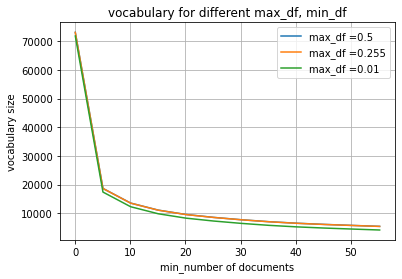

In [55]:
explore_df_range(data, (0.5,0.01,3), (0.0, 0.001,12))

max_df 0.900, min_df 0.000000 gives vocab size   8287
max_df 0.900, min_df 0.004286 gives vocab size   2307
max_df 0.900, min_df 0.008571 gives vocab size   1320
max_df 0.900, min_df 0.012857 gives vocab size   1017
max_df 0.900, min_df 0.017143 gives vocab size    770
max_df 0.900, min_df 0.021429 gives vocab size    614
max_df 0.900, min_df 0.025714 gives vocab size    533
max_df 0.900, min_df 0.030000 gives vocab size    447
max_df 0.050, min_df 0.000000 gives vocab size   8038
max_df 0.050, min_df 0.004286 gives vocab size   2058
max_df 0.050, min_df 0.008571 gives vocab size   1071
max_df 0.050, min_df 0.012857 gives vocab size    768
max_df 0.050, min_df 0.017143 gives vocab size    521
max_df 0.050, min_df 0.021429 gives vocab size    365
max_df 0.050, min_df 0.025714 gives vocab size    284
max_df 0.050, min_df 0.030000 gives vocab size    198


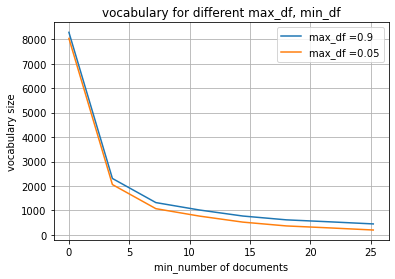

In [56]:
explore_df_range(data2, (0.9,0.05,2), (0.0, 0.03,8))

* TF

In [59]:
vectorizer = TfidfVectorizer( 
    lowercase=True,
    stop_words='english',
    ngram_range=(1,1),
    max_df=.95,
    min_df=2,
    max_features=None,
    binary=False,
    use_idf=False, # seems to use 1 + log(N/dft) smooth_idf=False,
    sublinear_tf=False,
    norm=None, # could use 'l2' 
)
vecs = vectorizer.fit_transform(data['Description']).toarray()

In [60]:
vectorizer2 = TfidfVectorizer( 
    lowercase=True,
    stop_words='english',
    ngram_range=(1,1),
    max_df=.95,
    min_df=2,
    max_features=None,
    binary=False,
    use_idf=False, # seems to use 1 + log(N/dft) smooth_idf=False,
    sublinear_tf=False,
    norm=None, # could use 'l2' 
)
vecs2 = vectorizer2.fit_transform(data2['Description']).toarray()


* Using TF-IDF with forum data

In [61]:
vectorizer = TfidfVectorizer( 
    lowercase=True,
    stop_words='english',
    ngram_range=(1,1),
    max_df=.95,
    min_df=2,
    max_features=None,
    binary=False,
    use_idf=True, # seems to use 1 + log(N/dft) smooth_idf=False,
    sublinear_tf=False,
    norm=None, # could use 'l2' 
)
vecs_tfidf = vectorizer.fit_transform(data['Description']).toarray()

• Using TF-IDF with raditt data

In [77]:
vectorizer = TfidfVectorizer( 
    lowercase=True,
    stop_words='english',
    ngram_range=(1,1),
    max_df=.95,
    min_df=2,
    max_features=None,
    binary=False,
    use_idf=True, # seems to use 1 + log(N/dft) smooth_idf=False,
    sublinear_tf=False,
    norm=None, # could use 'l2' 
)
vecs_tfidf_raditt = vectorizer.fit_transform(data2['Description']).toarray()

In [62]:
vocab = vectorizer.get_feature_names()
#vocab2 = vectorizer2.get_feature_names()

In [63]:
#vocab2[:100]

In [64]:
vecs.shape, vecs2.shape

((55236, 36242), (840, 4032))

In [79]:
vecs_tfidf.shape, vecs_tfidf_raditt.shape

((55236, 36242), (840, 4032))

* TF with 4-grams in forum data

In [66]:
vectorizer = TfidfVectorizer( 
    lowercase=True,
    stop_words='english',
    ngram_range=(4,4),
    max_df=.95,
    min_df=2,
    max_features=None,
    binary=False,
    use_idf=False, # seems to use 1 + log(N/dft) smooth_idf=False,
    sublinear_tf=False,
    norm=None, # could use 'l2' 
)
vecs_n = vectorizer.fit_transform(data['Description']).toarray()


In [ ]:
vectorizer = TfidfVectorizer( 
    lowercase=True,
    stop_words='english',
    ngram_range=(4,4),
    max_df=.95,
    min_df=2,
    max_features=None,
    binary=False,
    use_idf=False, # seems to use 1 + log(N/dft) smooth_idf=False,
    sublinear_tf=False,
    norm=None, # could use 'l2' 
)
vecs_n_raditt = vectorizer.fit_transform(data2['Description']).toarray()

In [67]:
vecs_n.shape

(55236, 82376)

In [ ]:
vecs_n_raditt.shape

In [ ]:
gensim.__version__

In [ ]:
/nfshome/store02/users/c.c1909412/EDA/glove.twitter.27B.25d.txt

In [105]:
!wc -l /nfshome/store02/users/c.c1909412/EDA/glove.twitter.27B.25d.txt

1193514 /nfshome/store02/users/c.c1909412/EDA/glove.twitter.27B.25d.txt


In [107]:
!sum /nfshome/store02/users/c.c1909412/EDA/wiki-news-300d-1M.vec

24631 2206142


In [ ]:
!sum /nfshome/store02/users/c.c1909412/EDA/glove.twitter.27B.200d.txt

In [68]:
# loading glove embeddings - only run this cell if you need these embeddings; it consumes memory and takes time!

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


# here I load the 300-dimension vectors; loading longer embeddings would require longer time and more RAM
path_of_downloaded_files = "/nfshome/store02/users/c.c1909412/EDA/glove.twitter.27B.200d.txt"

glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile("glove.twitter.27B.25d.txt")
glove2word2vec(glove_file, word2vec_glove_file)
glove_word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)


In [ ]:
glove_word_vectors .get('you').shape

In [69]:

def embed_word(word,vectors):
    '''
    yield an embedding dense vector corresponding to a word, using the embedding provided
    '''
    result = vectors['the']
    if (word in vectors.vocab):
        result=vectors[word]
    return result

# to use
myword = "hello"
embed_word(myword, glove_word_vectors)

def different_embed_word(word):
    results = np.empty((5,200), dtype=float)
    for i, vectors in enumerate([glove_word_vectors,glove_word_vector]):
        results[i] = vectors['the']
    return result
        

In [70]:
embeddings_size = 200

In [71]:
embeddings_average = []
for sentence in words_doc:
    sentence_embeddings = []
    if len(sentence) == 0:
        sentence_embeddings = np.zeros(embeddings_size)
    else:
        for word in sentence:
            word_embedding = embed_word(word, glove_word_vectors)
            sentence_embeddings.append(word_embedding)
    
        sentence_embeddings = np.array(sentence_embeddings).mean(axis=0)
    embeddings_average.append(sentence_embeddings)
embeddings_average = np.array(embeddings_average)

In [72]:
embeddings_average_raddit = []
for sentence in words_doc2:
    sentence_embeddings = []
    if len(sentence) == 0:
        sentence_embeddings = np.zeros(embeddings_size)
    else:
        for word in sentence:
            word_embedding = embed_word(word, glove_word_vectors)
            sentence_embeddings.append(word_embedding)
    
        sentence_embeddings = np.array(sentence_embeddings).mean(axis=0)
    embeddings_average_raddit.append(sentence_embeddings)
embeddings_average_raddit = np.array(embeddings_average_raddit)

In [73]:
embeddings_average.shape

(56838, 200)

In [74]:
embeddings_average_raddit.shape

(889, 200)

embeddings = []
for sentence in words_doc:
    sentence_embeddings= []
    for word in sentence:
        word_embedding = embed_word(word, glove_vectors)
        sentence_embeddings.append(word_embedding)
    sentence_embeddings = np.array(sentence_embeddings).mean(axis=0)
    embeddings.append(sentence_embeddings)
embeddings = np.array(embeddings)

In [75]:
longest_sentence_length = 0
for sentence in words_doc:
    if len(sentence) > longest_sentence_length:
        longest_sentence_length = len(sentence)
longest_sentence_length

2840

In [76]:
len(str(longest_sentence_length))

4

In [66]:
embeddings = []
for sentence in words_doc:
    sentence_embeddings = []
    for word in sentence:
        word_embedding = embed_word(word, glove_word_vectors)
        sentence_embeddings.append(word_embedding)
    for i in range(longest_sentence_length - len(sentence)):
        sentence_embeddings.append(np.zeros(embeddings_size))
    embeddings.append(sentence_embeddings)
embeddings = np.array(embeddings)


MemoryError: Unable to allocate 241. GiB for an array with shape (56838, 2840, 200) and data type float64

In [ ]:
embeddings = embeddings.reshape((-1, longest_sentence_length * embeddings_size))

In [ ]:
embeddings.shape

In [53]:
out_of_vocab = []
for sentence in words_doc:
    for word in sentence:         
        if word not in glove_word_vectors.vocab:
            out_of_vocab.append(word)
        

In [54]:
len(out_of_vocab)

5517256

## Embedding using fasttext(facebook)

In [113]:
# loading glove embeddings - only run this cell if you need these embeddings; it consumes memory and takes time!

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors



# here I load the 300-dimension vectors; loading longer embeddings would require longer time and more RAM
path_of_downloaded_files = "/nfshome/store02/users/c.c1909412/EDA/wiki-news-300d-1M.vec" 

fasttext_file = datapath(path_of_downloaded_files)
#word2vec_fasttext_file = get_tmpfile("wiki-news-300d-1M.vec")
#glove2word2vec(fasttext_file, word2vec_fasttext_file)
fasttext_word_vectors = KeyedVectors.load_word2vec_format(fasttext_file)

In [114]:
def embed_word_fasttext(word,vectors):
    '''
    yield an embedding dense vector corresponding to a word, using the embedding provided
    '''
    result = vectors['the']
    if (word in vectors.vocab):
        result=vectors[word]
    return result

# to use
myword = "hello"
embed_word(myword, fasttext_word_vectors)

def different_embed_word(word):
    results = np.empty((5,200), dtype=float)
    for i, vectors in enumerate([fasttext_word_vectors,fasttext_word_vectors]):
        results[i] = vectors['the']
    return result
        

In [121]:
embedding_size_fasttext = 300
embeddings_average_fasttext = []
for sentence in words_doc:
    sentence_embeddings = []
    if len(sentence) == 0:
        sentence_embeddings = np.zeros(embedding_size_fasttext)
    else:
        for word in sentence:
            word_embedding = embed_word(word,fasttext_word_vectors)
            sentence_embeddings.append(word_embedding)
    
        sentence_embeddings = np.array(sentence_embeddings).mean(axis=0)
    embeddings_average_fasttext.append(sentence_embeddings)
embeddings_average_fasttext = np.array(embeddings_average_fasttext)

In [123]:
embeddings_average_fasttext.shape

(56838, 300)

## K-means (using tf)
* Forum data

In [53]:
from gensim.models import Word2Vec

word2vec2 = Word2Vec(words_doc, min_count=2)


In [ ]:
from sklearn.cluster import KMeans
ks = np.arange(2,12)
scores=np.zeros_like(ks)
for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_transform(vecs)
    scores[i]=kmeans.score(vecs)
    print(f'tried {k} clusters...')


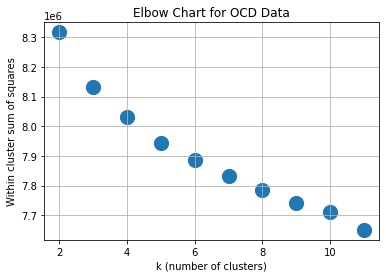

In [55]:
plt.scatter(ks,-scores,s=200)
plt.title('Elbow Chart for OCD Data')
plt.xlabel('k (number of clusters)')
plt.ylabel('Within cluster sum of squares')
plt.grid();

In [56]:
# recluster using best k
seed = 501
cls = KMeans(n_clusters=8, random_state=seed)
cls.fit_predict(vecs)
# to get cluster labels for the dataset used while # training the model (used for models that do not # support prediction on new dataset).
cls.labels_, cls.labels_.shape

(array([5, 6, 5, ..., 5, 6, 6], dtype=int32), (56838,))

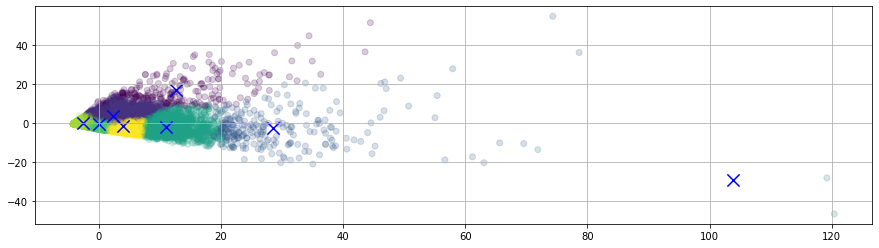

In [57]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=seed)
reduced_features = pca.fit_transform(vecs)
# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.figure(figsize=(15,4))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(vecs), alpha=0.2)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1],marker='x', s=150, c='b')
plt.grid();

In [ ]:
from sklearn.cluster import KMeans
ks = np.arange(2,12)
scores=np.zeros_like(ks)
for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_transform(vecs_n)
    scores[i]=kmeans.score(vecs_n)
    print(f'tried {k} clusters...')

tried 2 clusters...
tried 3 clusters...
tried 4 clusters...
tried 5 clusters...
tried 6 clusters...
tried 7 clusters...


In [ ]:
plt.scatter(ks,-scores,s=200)
plt.title('Elbow Chart for OCD Data')
plt.xlabel('k (number of clusters)')
plt.ylabel('Within cluster sum of squares')
plt.grid();

In [ ]:
# recluster using best k
seed = 501
cls = KMeans(n_clusters=8, random_state=seed)
cls.fit_predict(vecs)
# to get cluster labels for the dataset used while # training the model (used for models that do not # support prediction on new dataset).
cls.labels_, cls.labels_.shape

In [ ]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=seed)
reduced_features = pca.fit_transform(vecs)
# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.figure(figsize=(15,4))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(vecs), alpha=0.2)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1],marker='x', s=150, c='b')
plt.grid();

## Word embidding using Glove. 
* KMeans clustering (using word-embedding(glove))

In [ ]:
from sklearn.cluster import KMeans
ks = np.arange(2,12)
scores=np.zeros_like(ks)
for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_transform(embeddings_average)
    scores[i]=kmeans.score(embeddings_average)
    print(f'tried {k} clusters...')



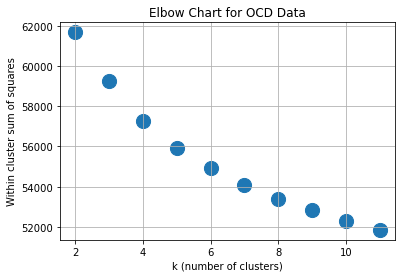

In [54]:
plt.scatter(ks,-scores,s=200)
plt.title('Elbow Chart for OCD Data')
plt.xlabel('k (number of clusters)')
plt.ylabel('Within cluster sum of squares')
plt.grid();

In [57]:
# recluster using best k
seed = 501
cls = KMeans(n_clusters=10, random_state=seed)
cls.fit_predict(embeddings_average)
# to get cluster labels for the dataset used while # training the model (used for models that do not # support prediction on new dataset).
cls.labels_, cls.labels_.shape

(array([6, 6, 1, ..., 0, 0, 1], dtype=int32), (56838,))

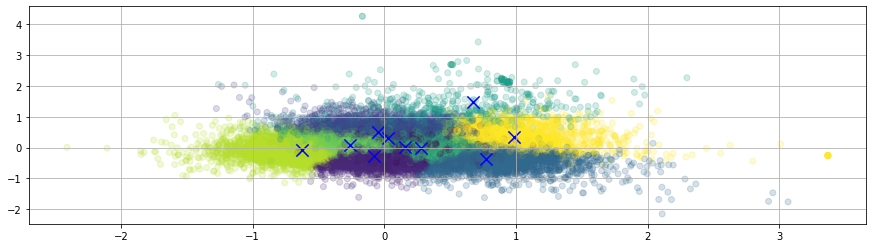

In [58]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=seed)
reduced_features = pca.fit_transform(embeddings_average)
# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.figure(figsize=(15,4))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(embeddings_average), alpha=0.2)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1],marker='x', s=150, c='b')
plt.grid();

## word-embidding for raditt data using Glove 
* KMeans clustering 

In [43]:
from sklearn.cluster import KMeans
ks = np.arange(2,12)
scores=np.zeros_like(ks)
for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_transform(embeddings_average_raddit)
    scores[i]=kmeans.score(embeddings_average_raddit)
    print(f'tried {k} clusters...')



tried 2 clusters...
tried 3 clusters...
tried 4 clusters...
tried 5 clusters...
tried 6 clusters...
tried 7 clusters...
tried 8 clusters...
tried 9 clusters...
tried 10 clusters...
tried 11 clusters...


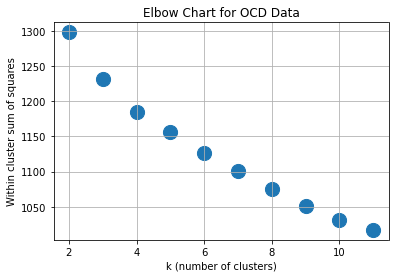

In [44]:
plt.scatter(ks,-scores,s=200)
plt.title('Elbow Chart for OCD Data')
plt.xlabel('k (number of clusters)')
plt.ylabel('Within cluster sum of squares')
plt.grid();

In [46]:
# recluster using best k
seed = 501
cls = KMeans(n_clusters=10, random_state=seed)
cls.fit_predict(embeddings_average_raddit)
# to get cluster labels for the dataset used while # training the model (used for models that do not # support prediction on new dataset).
cls.labels_, cls.labels_.shape

(array([7, 7, 3, 3, 7, 7, 4, 3, 5, 5, 5, 5, 7, 4, 9, 4, 4, 4, 1, 7, 7, 7,
        7, 7, 3, 7, 3, 3, 5, 9, 5, 7, 9, 9, 7, 9, 1, 9, 7, 7, 1, 1, 7, 4,
        5, 7, 9, 1, 7, 7, 4, 9, 9, 7, 9, 5, 7, 7, 9, 3, 4, 3, 9, 7, 5, 9,
        4, 5, 7, 4, 1, 7, 9, 9, 7, 9, 1, 5, 1, 7, 7, 1, 5, 4, 3, 1, 7, 9,
        9, 9, 9, 7, 9, 9, 9, 7, 3, 7, 7, 5, 9, 1, 4, 4, 7, 7, 1, 7, 9, 0,
        5, 9, 4, 0, 7, 7, 7, 9, 4, 9, 7, 7, 3, 7, 7, 4, 9, 1, 7, 3, 4, 3,
        3, 4, 7, 7, 9, 1, 1, 4, 3, 7, 7, 6, 3, 7, 4, 9, 7, 1, 7, 9, 9, 7,
        7, 1, 1, 9, 4, 7, 1, 9, 4, 7, 5, 7, 4, 7, 1, 2, 9, 5, 3, 9, 1, 8,
        7, 7, 7, 1, 5, 5, 7, 3, 3, 4, 7, 7, 7, 9, 1, 1, 7, 1, 9, 9, 7, 7,
        4, 9, 5, 1, 1, 7, 9, 9, 9, 0, 7, 1, 9, 5, 7, 3, 3, 0, 3, 3, 4, 5,
        7, 7, 9, 5, 9, 5, 4, 7, 3, 7, 7, 9, 5, 9, 7, 1, 7, 3, 7, 5, 7, 3,
        9, 3, 7, 3, 1, 7, 9, 1, 9, 7, 9, 7, 7, 9, 9, 7, 7, 7, 9, 7, 9, 7,
        9, 7, 9, 5, 7, 7, 7, 1, 9, 7, 7, 9, 7, 7, 9, 1, 7, 1, 7, 1, 4, 1,
        4, 9, 3, 4, 7, 7, 9, 1, 9, 4, 

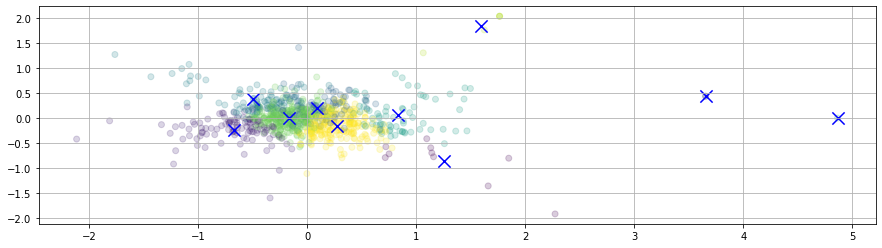

In [47]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=seed)
reduced_features = pca.fit_transform(embeddings_average_raddit)
# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.figure(figsize=(15,4))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(embeddings_average_raddit), alpha=0.2)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1],marker='x', s=150, c='b')
plt.grid();

In [124]:
from sklearn.cluster import KMeans
ks = np.arange(2,12)
scores=np.zeros_like(ks)
for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_transform(embeddings_average_fasttext)
    scores[i]=kmeans.score(embeddings_average_fasttext)
    print(f'tried {k} clusters...')

tried 2 clusters...
tried 3 clusters...
tried 4 clusters...
tried 5 clusters...
tried 6 clusters...
tried 7 clusters...
tried 8 clusters...
tried 9 clusters...
tried 10 clusters...
tried 11 clusters...


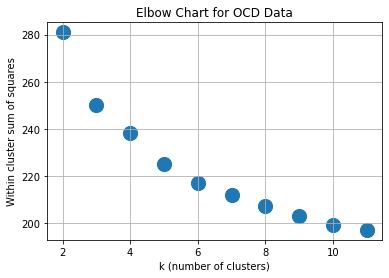

In [125]:
plt.scatter(ks,-scores,s=200)
plt.title('Elbow Chart for OCD Data')
plt.xlabel('k (number of clusters)')
plt.ylabel('Within cluster sum of squares')
plt.grid();

In [126]:
# recluster using best k
seed = 501
cls = KMeans(n_clusters=10, random_state=seed)
cls.fit_predict(embeddings_average_fasttext)
# to get cluster labels for the dataset used while # training the model (used for models that do not # support prediction on new dataset).
cls.labels_, cls.labels_.shape

(array([2, 7, 2, ..., 9, 7, 2], dtype=int32), (56838,))

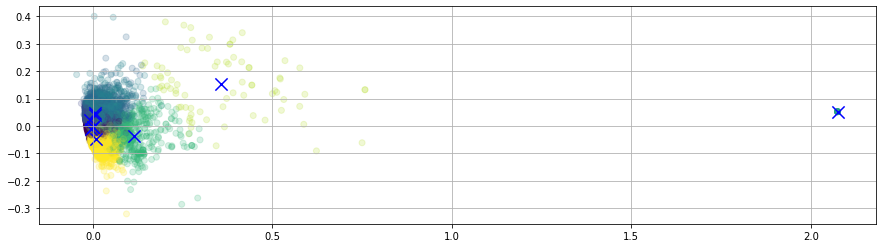

In [127]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=seed)
reduced_features = pca.fit_transform(embeddings_average_fasttext)
# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.figure(figsize=(15,4))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(embeddings_average_fasttext), alpha=0.2)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1],marker='x', s=150, c='b')
plt.grid();

## K-means with TF (4-grams)


In [58]:
from sklearn.cluster import KMeans
ks = np.arange(2,12)
scores=np.zeros_like(ks)
for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_transform(vecs_n)
    scores[i]=kmeans.score(vecs_n)
    print(f'tried {k} clusters...')

tried 2 clusters...
tried 3 clusters...
tried 4 clusters...
tried 5 clusters...
tried 6 clusters...
tried 7 clusters...
tried 8 clusters...
tried 9 clusters...
tried 10 clusters...
tried 11 clusters...


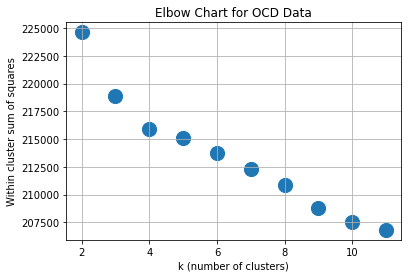

In [59]:
plt.scatter(ks,-scores,s=200)
plt.title('Elbow Chart for OCD Data')
plt.xlabel('k (number of clusters)')
plt.ylabel('Within cluster sum of squares')
plt.grid();

In [60]:
# recluster using best k
seed = 501
cls = KMeans(n_clusters=5, random_state=seed)
cls.fit_predict(vecs_n)
# to get cluster labels for the dataset used while # training the model (used for models that do not # support prediction on new dataset).
cls.labels_, cls.labels_.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32), (56838,))

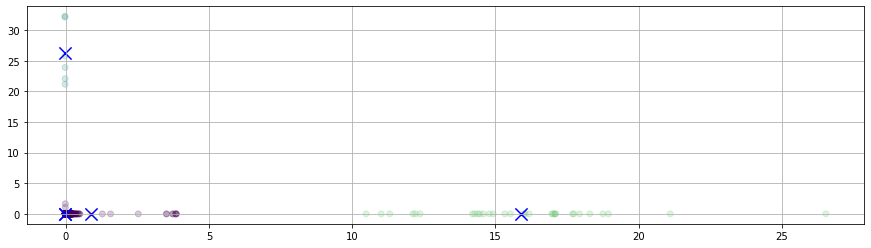

In [61]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=seed)
reduced_features = pca.fit_transform(vecs_n)
# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.figure(figsize=(15,4))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(vecs_n), alpha=0.2)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1],marker='x', s=150, c='b')
plt.grid();

# K-means with tf-idf for Forum data

In [62]:
from sklearn.cluster import KMeans
ks = np.arange(2,12)
scores=np.zeros_like(ks)
for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_transform(vecs_tfidf)
    scores[i]=kmeans.score(vecs_tfidf)
    print(f'tried {k} clusters...')

tried 2 clusters...
tried 3 clusters...
tried 4 clusters...
tried 5 clusters...
tried 6 clusters...
tried 7 clusters...
tried 8 clusters...
tried 9 clusters...
tried 10 clusters...
tried 11 clusters...


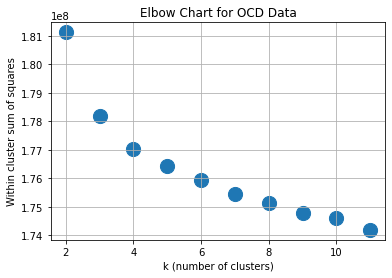

In [63]:
plt.scatter(ks,-scores,s=200)
plt.title('Elbow Chart for OCD Data')
plt.xlabel('k (number of clusters)')
plt.ylabel('Within cluster sum of squares')
plt.grid();

In [64]:
 #recluster using best k
seed = 501
cls = KMeans(n_clusters=5, random_state=seed)
cls.fit_predict(vecs_tfidf)
# to get cluster labels for the dataset used while # training the model (used for models that do not # support prediction on new dataset).
cls.labels_, cls.labels_.shape

(array([3, 3, 3, ..., 3, 3, 3], dtype=int32), (56838,))

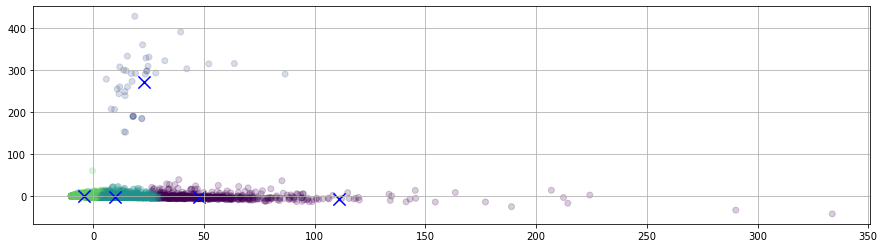

In [65]:
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=seed)
reduced_features = pca.fit_transform(vecs_tfidf)
# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.figure(figsize=(15,4))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(vecs_tfidf), alpha=0.2)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1],marker='x', s=150, c='b')
plt.grid();

## K-means
* Raditt data

In [66]:
from gensim.models import Word2Vec

word2vec2 = Word2Vec(words_doc2, min_count=2)

In [67]:
from sklearn.cluster import KMeans
ks = np.arange(2,12)
scores=np.zeros_like(ks)
for i,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_transform(vecs2)
    scores[i]=kmeans.score(vecs2)
    print(f'tried {k} clusters...')

tried 2 clusters...
tried 3 clusters...
tried 4 clusters...
tried 5 clusters...
tried 6 clusters...
tried 7 clusters...
tried 8 clusters...
tried 9 clusters...
tried 10 clusters...
tried 11 clusters...


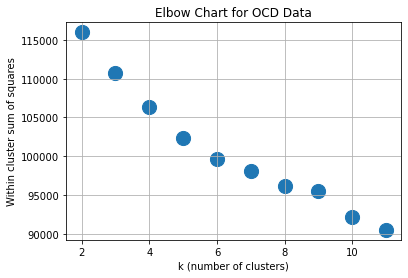

In [68]:
plt.scatter(ks,-scores,s=200)
plt.title('Elbow Chart for OCD Data')
plt.xlabel('k (number of clusters)')
plt.ylabel('Within cluster sum of squares')
plt.grid();

In [69]:
# recluster using best k
seed = 501
cls = KMeans(n_clusters=5, random_state=seed)
cls.fit_predict(vecs2)
# to get cluster labels for the dataset used while # training the model (used for models that do not # support prediction on new dataset).
cls.labels_, cls.labels_.shape

(array([0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
        0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 0, 0, 0, 3, 0, 3, 3, 0, 3,
        3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 2, 3, 3, 0, 3, 3, 3, 3,
        3, 0, 3, 0, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 1, 3, 3, 3,
        3, 0, 3, 3, 0, 3, 0, 0, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3,
        3, 3, 0, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3,
        3, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 0, 0, 3, 3, 3, 0, 0, 3, 1, 3, 0, 1, 3, 3, 3, 0, 3, 3, 1, 0, 3,
        3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 0, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 3, 0, 3, 0,
        3, 0, 0, 3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3,
        3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 

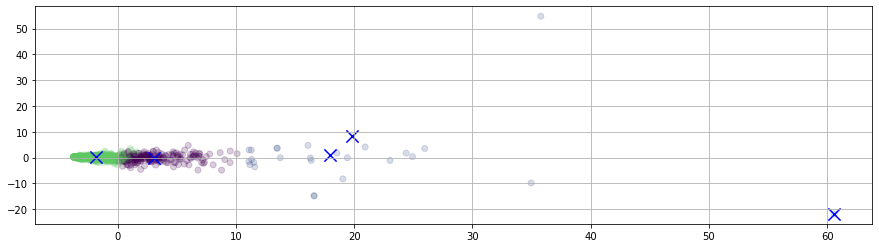

In [70]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=seed)
reduced_features = pca.fit_transform(vecs2)
# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.figure(figsize=(15,4))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(vecs2), alpha=0.2)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1],marker='x', s=150, c='b')
plt.grid();

## LDA with BoW 
* Forum data

In [36]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess 
from gensim.models import CoherenceModel

In [37]:
 # Create Dictionary as Gensim requires dic of all terms and their respective 
    #Create document term matrix
id2word = corpora.Dictionary(words_doc) 
# Create Corpus
texts = words_doc
# Term Document Frequency
corpus = [id2word.doc2bow(words_doc) for words_doc in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 7), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 2), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1)]]


In [38]:
 # Have the corpus(term-doc matrix) and id2word (dictionary), need to specify no of topics and iteration
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,  # BoW
                                           id2word=id2word, # vocanulary of the corpus
                                           num_topics=9, 
                                           random_state=100, 
                                           update_every=1, 
                                           chunksize=100, 
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
print(lda_model.print_topics())

[(0, '0.028*"day" + 0.021*"back" + 0.020*"work" + 0.020*"year" + 0.020*"week" + 0.018*"time" + 0.018*"got" + 0.018*"last" + 0.014*"said" + 0.013*"month"'), (1, '0.027*"hand" + 0.014*"house" + 0.011*"car" + 0.011*"touch" + 0.010*"clean" + 0.010*"wash" + 0.010*"blood" + 0.010*"room" + 0.009*"contamination" + 0.009*"door"'), (2, '0.041*"u" + 0.023*"uk" + 0.018*"member" + 0.014*"website" + 0.012*"forum" + 0.012*"thread" + 0.012*"ocd" + 0.011*"view" + 0.011*"email" + 0.010*"sufferer"'), (3, '0.035*"child" + 0.027*"girl" + 0.026*"remember" + 0.021*"relationship" + 0.019*"boyfriend" + 0.019*"kid" + 0.019*"sexual" + 0.017*"gay" + 0.014*"would" + 0.014*"woman"'), (4, '0.376*"thought" + 0.042*"intrusive" + 0.023*"mind" + 0.019*"urge" + 0.016*"harm" + 0.011*"daughter" + 0.011*"head" + 0.011*"act" + 0.011*"image" + 0.011*"anxiety"'), (5, '0.194*"im" + 0.132*"dont" + 0.075*"cant" + 0.054*"ive" + 0.032*"didnt" + 0.024*"thats" + 0.017*"wont" + 0.015*"doesnt" + 0.015*"alot" + 0.014*"recovery"'), (6, '

In [39]:
import pyLDAvis.gensim
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.270311 -0.065184       1        1  35.256573
6      0.211431  0.030313       2        1  25.969945
0      0.236149 -0.003495       3        1  16.309177
1     -0.006675  0.034204       4        1   5.426126
7     -0.090276  0.244559       5        1   4.903662
3      0.002524 -0.049866       6        1   4.142018
4     -0.182217 -0.361930       7        1   3.654204
2     -0.173668  0.153131       8        1   2.558339
5     -0.267578  0.018267       9        1   1.779956, topic_info=         Term          Freq         Total Category  logprob  loglift
89    thought  76615.000000  76615.000000  Default  30.0000  30.0000
133       ocd  97188.000000  97188.000000  Default  29.0000  29.0000
989        im  19205.000000  19205.000000  Default  28.0000  28.0000
52       like  66307.000000  66307.000000  Default  27.0000  27.0000
35       feel  64631.000000  64631.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
3144   medium    429.424977    430.402990   Topic9  -5.4426   4.0263
2739      omg    420.920639    421.897734   Topic9  -5.4626   4.0263
1706     alot   1499.882436   2186.397185   Topic9  -4.1919   3.6517
682         u    972.095683   8972.788125   Topic9  -4.6256   1.8061
461       ill    624.242798   3176.002175   Topic9  -5.0685   2.4017

[438 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1855      3  0.682583          1
1855      5  0.317264          1
203       3  0.999875          2
2581      8  0.998940       2006
3746      7  0.998091       2010
...     ...       ...        ...
244       6  0.066021       year
1633      1  0.058405  yesterday
1633      3  0.941276  yesterday
106       6  0.999336      young
1744      6  0.999072    younger

[563 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 1, 2, 8, 4, 5, 3, 6])

## LDA with BoW 
* Raditt data

In [40]:
 # Create Dictionary as Gensim requires dic of all terms and their respective 
    #Create document term matrix
id2word = corpora.Dictionary(words_doc2) 
# Create Corpus
texts = words_doc2
# Term Document Frequency
corpus = [id2word.doc2bow(words_doc2) for words_doc2 in texts]
# View
print(corpus[:1])

/home/c.c1909412/.conda/envs/ocd/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 3), (7, 2), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 6), (26, 1), (27, 1), (28, 2), (29, 2), (30, 1), (31, 2), (32, 1), (33, 1), (34, 3), (35, 1), (36, 2), (37, 1), (38, 2), (39, 2), (40, 2), (41, 1), (42, 7), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 6), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 3), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 3), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 9), (73, 1), (74, 1), (75, 1), (76, 1), (77, 4), (78, 4), (79, 2), (80, 3), (81, 2), (82, 1)]]


In [41]:
 # Have the corpus(term-doc matrix) and id2word (dictionary), need to specify no of topics and iteration
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,  # BoW
                                           id2word=id2word, # vocanulary of the corpus
                                           num_topics=9, 
                                           random_state=100, 
                                           update_every=1, 
                                           chunksize=100, 
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
print(lda_model.print_topics())

/home/c.c1909412/.conda/envs/ocd/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, '0.029*"thought" + 0.028*"like" + 0.016*"feel" + 0.015*"think" + 0.014*"get" + 0.011*"even" + 0.011*"thing" + 0.010*"person" + 0.009*"something" + 0.009*"make"'), (1, '0.012*"bed" + 0.011*"demon" + 0.007*"extremely" + 0.006*"ritual" + 0.006*"period" + 0.006*"driving" + 0.006*"ima" + 0.005*"note" + 0.005*"conversation" + 0.005*"eye"'), (2, '0.018*"asleep" + 0.014*"nightmare" + 0.009*"subconsciously" + 0.007*"racing" + 0.007*"vivid" + 0.007*"swear" + 0.007*"judge" + 0.006*"total" + 0.003*"tiniest" + 0.002*"eyebrow"'), (3, '0.017*"dream" + 0.008*"second" + 0.008*"argument" + 0.008*"exercise" + 0.008*"remembered" + 0.007*"addiction" + 0.006*"nowhere" + 0.006*"interview" + 0.006*"acted" + 0.006*"wet"'), (4, '0.028*"ocd" + 0.015*"like" + 0.014*"know" + 0.012*"time" + 0.012*"feel" + 0.010*"thing" + 0.009*"really" + 0.009*"day" + 0.009*"one" + 0.009*"would"'), (5, '0.016*"age" + 0.015*"girl" + 0.014*"looked" + 0.013*"attracted" + 0.013*"old" + 0.012*"hocd" + 0.011*"pocd" + 0.009*"child" +

In [42]:
import pyLDAvis.gensim
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/c.c1909412/.conda/envs/ocd/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.329408  0.017048       1        1  52.251784
0      0.317704  0.001685       2        1  31.440017
1     -0.118567  0.293948       3        1   7.103436
5     -0.075416 -0.165175       4        1   3.875002
7     -0.112263 -0.124393       5        1   3.238910
3     -0.116968 -0.012423       6        1   1.661392
6     -0.080378 -0.006682       7        1   0.265580
2     -0.073530 -0.002584       8        1   0.128703
8     -0.069990 -0.001423       9        1   0.035176, topic_info=             Term         Freq        Total Category  logprob  loglift
45            ocd  1128.000000  1128.000000  Default  30.0000  30.0000
72        thought  1016.000000  1016.000000  Default  29.0000  29.0000
31           like  1302.000000  1302.000000  Default  28.0000  28.0000
389          life   335.000000   335.000000  Default  27.0000  27.0000
76           want   495.000000   495.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
6489        steer     0.003544     0.894541   Topic9  -8.9352   2.4215
6490  suicidality     0.003544     0.894541   Topic9  -8.9352   2.4215
6491      upfront     0.003544     0.894541   Topic9  -8.9352   2.4215
4552         mary     0.003546     2.403120   Topic9  -8.9347   1.4338
5082       butter     0.003524     6.027110   Topic9  -8.9409   0.5081

[423 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
555       1  0.547614       10
555       4  0.434314       10
556       1  0.359325       12
556       4  0.635729       12
2734      1  0.330523       16
...     ...       ...      ...
628       6  0.266977    write
1594      3  0.987374  writing
141       1  0.835785     year
141       2  0.120521     year
141       4  0.044540     year

[379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 6, 8, 4, 7, 3, 9])

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
• using tf

**optimal of eps**

• Clustering using tf as a feature

In [45]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(vecs) 
distances, indices = neighbors_fit.kneighbors(vecs)

/home/c.c1909412/.conda/envs/ocd/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/c.c1909412/.conda/envs/ocd/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


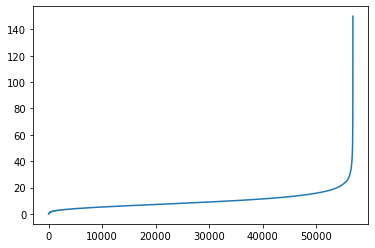

In [46]:
# Sort distance values by ascending value and plot

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

/home/c.c1909412/.conda/envs/ocd/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/c.c1909412/.conda/envs/ocd/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

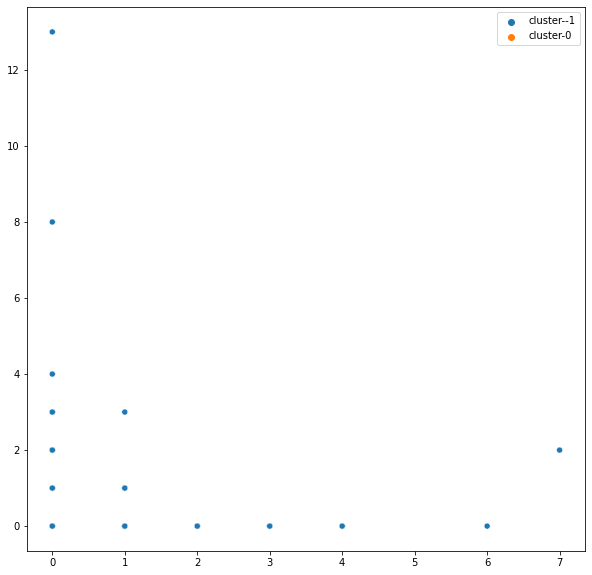

In [47]:
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import numpy as np


db = DBSCAN(eps=0.3, min_samples=10).fit(vecs)
labels = db.labels_
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(vecs[:,0], vecs[:,1], hue=["cluster-{}".format(x) for x in labels])

In [ ]:
# Compute DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
labels = db.labels_

no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)